# Vesuvius Challenge - Ink Detection

In this challenge, which I personally find fascinating, the effort is to resurrect an ancient library buried under the ashes of the Vesuvius volcano some 2000 years ago. The library was located in a Roman villa, near Pompeii, and contained thousand of scrolls. They were discovered a few hundred years ago and this has led to the quest to be able to read them using today's technology.

The scrolls were carbonized and remain unreadable to today, and it will require special techniques such as 3d Xrays scans to read the scrolls by detecting the ink, hence the challenge name 'Vesuvius Ink Detection'.


### Objective


The result of the segmentation should help in revealing the content.

**Imagine the secrets of Roman and Greek philosophy, science, literature, mathematics, poetry, and politics, which are locked away in these lumps of ash, waiting to be read!**

A team of scientists led by Dr. Brent Seales have used X-Ray tomography and CV to read scrolls found in other places, as old as Roman scrolls. However in these scrolls carbon was used affording no X-ray against the carbon-based papyrus.
Under infrared light, using particle accelerator, some detached parts of the papyrus are readable, which led to the use of machine learning to identify letters in ink with known samples. To desribe it is to use machine learning for the invisible link with ground truth data.
https://scrollprize.org/img/landing/anim2b_4.webm
The input to the accelerator were two scrolls and several fragments with 4-6 um resolution and 16 bit density of data per voxel, and they believe the machine learning modeling will be able to pick the characters from the subtle areas where the ink is detectable.

In early 2023 this team at University of Kentucky has achieved a breakthrough in being able to detect the ink with Xray technology thus being able in the future to uncover the characters written in the scrolls.

The challenge here is to be able to understand the problem and contribute in a modest way to expedite the reading of the scrolls.

**After 275 years, the problem with the ancient library comes to a software. **


### Dataset

It is customary to begin with understanging the Dataset and perform the  Exploratory Data Analysis (EDA) prior to working on the challenge, for both our own understanding and better feature modeling.
The input data are scans and we have to produce binary images of same size as scrolls with the ink pixels represented by 1. In CV it is the segmentation task, and the score calculated is called Dice Similarity Coefficient, which is also known as F1 score used in MRI scanning.

**Data Exploratory**

- Visualize the content of the given papyrus scroll by combining the scans from the dataset (we include train and test data).
- Shape the images (dataset comes with 3 scrolls for training and 2 scrolls for testing). Gather some statistics on the shape and size(number of pixels). Images come in different sizes.
- The dataset includes 'ir' and 'inklabels' for training. Masks are binary iamges that delimit the scroll from the backgrouund.
  - [train/test]/[fragment_id]/mask.png — a binary mask of which pixels contain data
  - train/[fragment_id]/inklabels.png — a binary mask of the ink vs no-ink labels
  - train/[fragment_id]/inklabels_rle.csv — a run-length-encoded version of the labels, generated using this script
  - train/[fragment_id]/ir.png — the infrared photo on which the binary mask is based

In [ ]:
""" download dataset from Kaggle
from google.colab import drive
import os, shutil

!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c vesuvius-challenge-ink-detection
!cd /content/drive/MyDrive/A_Vesuvius/
!7z e /content/drive/MyDrive/A_Vesuvius/vesuvius-challenge-ink-detection.zip
"""

Implementation with Python

In [ ]:
import os, math, gc
import numpy as np
import pandas as pd
import lovely_numpy as ln
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from tqdm.auto import tqdm
from collections import defaultdict
from io import StringIO
from pathlib import Path
from typing import Tuple, List
import glob
import PIL
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact, fixed

PREFIX = f'/content/drive/MyDrive/A_Vesuvius/'
PATHTRAIN = f'/content/drive/MyDrive/A_Vesuvius/'

In [ ]:
!ls /content/drive/MyDrive/A_Vesuvius/train/1
!ls /content/drive/MyDrive/A_Vesuvius/train/2/surface_volume | wc

inklabels.png  inklabels_rle.csv  ir.png  mask.png  surface_volume
     66      66     459


### Work with the Dataset

In [ ]:
!pip install pytorch_lightning
!pip install monai

In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import pytorch_lightning as pl
import torchvision as torchvision
import torch.nn as nn
import torch.optim as optim
import monai
from monai.data import DataLoader, CSVDataset
from monai.inferers import sliding_window_inference
from torchmetrics import Dice
from torchmetrics import MetricCollection
from monai.visualize import matshow3d

In [ ]:
""" main configurations for the dataset

train_scroll_1_size = (8181, 6330), 51785730
train_scroll_2_size = (14830, 9506), 140973980
train_scroll_3_size = (7606, 5249), 39923894

buffer - x, y patch size for training
z_start - offset of slices in the z direction
z_dimension - number of slices in the z direction (0-64: 65)
validation_rectangle - validation rectangle removed for validation set
shared_height - height to resize all scrolls
scroll fragments - scrolls to be used

BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VesuviusDataset_Lit(
  buffer = 30,
  z_start = 27,
  z_dimension = 10,
  validation_rectangle = (1100, 3500, 700, 950), # (1250, 1500, 780, 850)
  shared_height = 8000, # 2000
  downsampling = None,
  scroll_fragments = [1, 2, 3],
  stage = 'train', # or 'test'
  shuffle = True,
  batch_size = 32,
  num_workers = 4,
  on_gpu = False
)
"""
print()

In [ ]:
"""
An abstract class representing a Dataset

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite __getitem__, supporting fetching a data
sample for a given key. Subclasses could also optionally overwrite __len__,
which is expected to return the size of the dataset by many
~torch.utils.data.Sampler implementations and the default options
of ~torch.utils.data.DataLoader
"""
class VesuviusDataset(Dataset):
  def __init__(self, image_stack, label, pixels, buffer, z_dimension):
    super().__init__()

    self.image_stack = image_stack
    self.label = label
    self.pixels = pixels
    self.buffer = buffer
    self.z_dimension = z_dimension

  def __getitem__(self, index):
    y, x = self.pixels[index]

    subvolume = self.image_stack[:,
                                 y - self.buffer: y + self.buffer +1,
                                 x - self.buffer: x + self.buffer +1
              ].view(1, self.z_dimension, self.buffer*2 +1, self.buffer*2 +1 )

    ink_label = self.label[y, x].view(1)

    return subvolume, ink_label
    # use this for visualization if need to use coordinates
    # return subvolume, ink_label, (y, x)

  def __len__(self):
    return len(self.pixels)

In [ ]:
"""
An abstract class representing a Dataset

Same implementation as above with changes for a separate model
"""
class VesuviusDataset_U(Dataset):
  def __init__(self, image_stack, label, pixels, buffer, z_dimension):
    super().__init__()

    self.image_stack = image_stack
    self.label = label
    self.pixels = pixels
    self.buffer = buffer
    self.z_dimension = z_dimension

  def __getitem__(self, index):
    y, x = self.pixels[index]

    subvolume = self.image_stack[
      :, y - self.buffer: y + self.buffer +1, x - self.buffer: x + self.buffer+1
    ].view(1, self.z_dimension, self.buffer*2 +1, self.buffer*2 +1)

    ink_label = self.label[
      y - self.buffer: y + self.buffer +1, x - self.buffer: x + self.buffer+1
    ].view(1, self.buffer*2 +1, self.buffer*2 +1)

    mask = self.mask[
      y - self.buffer: y + self.buffer +1, x - self.buffer: x + self.buffer+1
    ].view(1, self.buffer*2 +1, self.buffer*2 +1)

    return subvolume, ink_label, mask

  def __len__(self):
    return len(self.pixels)

In [ ]:
torch.utils.data.Dataset.__dict__

Data Processing for removal -- after

In [ ]:
"""
def resize(image):
  width, height = image.size
  aspect_ratio = width/height
  shared_height = 8000
  new_width = int(shared_height * aspect_ratio)
  new_size = (new_width, shared_height)
  image = image.resize(new_size)
  return image
"""

In [ ]:
"""
z_slices, labels, masks = [[] for _ in range(3)], [[] for _ in range(3)], [[] for _ in range(3)]
for i in [1, 2, 3]:
  z_slices[i-1] += sorted(glob.glob(
      f'{PATHTRAIN}/train/{i}/surface_volume/*.tif'))[1:6]
  img_l = Image.open(f'{PATHTRAIN}train/{i}/inklabels.png')
  img_l = resize(img_l)
  labels[i -1]= torch.from_numpy(np.array(img_l)).gt(0).float()
  img_m = Image.open(f'{PATHTRAIN}train/{i}/mask.png').convert('1')
  img_m = resize(img_m)
  masks[i -1] = np.array(img_m)

z_slices
labels,
len(z_slices)
"""

In [ ]:
"""
images = [[] for _ in range(3)]
for i in range(3):
  images_ = []
  for index_, filename in tqdm(enumerate(z_slices[i])):
    img_ = Image.open(filename)
    img_ = resize(img_)
    z_slice = np.array(img_, dtype='float32')/65535.0
    images_.append(z_slice)
  images[i] = torch.stack([torch.from_numpy(image) for image in images_], dim=0)
"""

5it [00:08,  1.73s/it]
5it [00:15,  3.17s/it]
5it [00:09,  1.99s/it]


In [ ]:
"""
images[0].shape, images[1].shape, images[2].shape, \
labels[0].shape, labels[1].shape, labels[2].shape, \
masks[0].shape, masks[1].shape, masks[2].shape
"""

(torch.Size([5, 8000, 6189]),
 torch.Size([5, 8000, 5127]),
 torch.Size([5, 8000, 5520]),
 torch.Size([8000, 6189]),
 torch.Size([8000, 5127]),
 torch.Size([8000, 5520]),
 (8000, 6189),
 (8000, 5127),
 (8000, 5520))

In [ ]:
"""
images_tensors = torch.cat([image for image in images], axis=-1)
labels_tensors = torch.cat([label for label in labels], axis=1)
masks_tensors = np.concatenate([mask for mask in masks], axis=-1)
"""

In [ ]:
"""
images_tensors.shape, labels_tensors.shape, masks_tensors.shape
"""

(torch.Size([5, 8000, 16836]), torch.Size([8000, 16836]), (8000, 16836))

In [ ]:
""" --
PREFIX = f'/content/drive/MyDrive/A_Vesuvius/'
Z_START = 1      # First slice in the z direction to use
Z_DIM = 10        # Number of slices in the z direction
shared_height = 8000
a_slices = [ [], [], []]
for i in [1, 2, 3]:
  a_slices[i -1] += sorted(glob.glob(f'{PATHTRAIN}{i}/surface_volume/*.tif'))
for idx, file in tqdm(enumerate(a_slices)):
  print(idx, file, end='\n')
len(a_slices), np.array(a_slices).shape,

"""

3it [00:00, 12384.76it/s]

0 []
1 []
2 []


(3, (3, 0))

In [ ]:
class VesuviusDataset_Lit(pl.LightningDataModule):
  def __init__(self,
               buffer = 30,
               z_start = 27,
               z_dimension = 10,
               validation_rectangle = (1100, 3500, 700, 950),
               shared_height = 8000,
               downsampling = None,
               scroll_fragments = [1, 2, 3],
               stage = 'train',
               shuffle = True,
               batch_size = 32,
               num_workers = 4,
               on_gpu = False
      ):

      super().__init__()
      self.save_hyperparameters()

      self.buffer = buffer
      self.z_start = z_start
      self.num_workers = num_workers
      self.z_dimension = z_dimension
      self.validation_rectangle = validation_rectangle
      self.shared_height = shared_height
      self.downsampling = downsampling
      self.scroll_fragments = scroll_fragments
      self.stage = stage
      self.shuffle = shuffle
      self.batch_size = batch_size
      self.on_gpu = on_gpu
      self.prepare_data_per_node = True

  def prepare_data(self, *args, **kwargs):
    if self.stage == 'train':

      z_slices = [[] for i in range(len(self.scroll_fragments))]
      z_slices_tensors = [[] for i in range(len(self.scroll_fragments))]
      labels = [[] for i in range(len(self.scroll_fragments))]
      masks =  [[] for i in range(len(self.scroll_fragments))]

      """ get z_slices .tif(s) files for scroll fragments [1, 2, 3]
          get labels, and masks for the scroll 1, 2, 3  """
      for i in self.scroll_fragments:
        z_slices[i -1] += sorted(
            glob.glob(f'{PATHTRAIN}train/{i}/surface_volume/*.tif'))[
                              self.z_start : self.z_start + self.z_dimension]
        labels[i -1] = self.load_labels('train', i) # np.array format
        masks[i -1] = self.load_masks('train', i)   # np.array format

      for i in range(len(self.scroll_fragments)):
          z_slices_tensors[i] = self.load_slices(z_slices[i]) # np.array format
      del z_slices
      images_tensors = torch.cat([image_ for image_ in z_slices_tensors],axis=-1)
      del z_slices_tensors
      labels_tensors = torch.cat([label_ for label_ in labels], axis=-1)
      del labels
      masks_tensors = np.concatenate([mask_ for mask_ in masks], axis=-1)
      del masks

      """ obtain train and validation pixels
      pixels inside the rectangles are of the validation set,
      pixels outside of the rectangles belong to the train set """
      train_pixels, validation_pixels = self.split_train_validate(masks_tensors)
      self.mask = masks_tensors

      """ prepare data train and validation """
      self.data_train = VesuviusDataset(
                            image_stack = images_tensors,
                            label = labels_tensors,
                            pixels = train_pixels,
                            buffer = self.buffer,
                            z_dimension = self.z_dimension)

      self.data_val = VesuviusDataset(image_stack = images_tensors,
                          label = labels_tensors, pixels = validation_pixels,
                          buffer = self.buffer, z_dimension = self.z_dimension)

      """ memory management before returning """
      del images_tensors ; del labels_tensors ;  del masks_tensors
      del train_pixels ; del validation_pixels

    elif self.stage == 'test':
      z_slices = [ [], [] ]
      """
      for i, label_ in enumerate(['a', 'b']):
        z_slices[i] = sorted(
          glob.glob(f'{PREFIX}test/{label_}/surface_volume/*.tif'))
      """

  def train_dataloader(self, *args, **kwargs):
    """ constructor for train dataloader  """
    return DataLoader(self.data_train, shuffle=True, batch_size=self.batch_size,
                      num_workers = self.num_workers, pin_memory = self.on_gpu)

  def test_dataloader(self, *args, **kwargs):
    """ constructor for test dataloader  """
    return DataLoader(self.data_test, shuffle=False, batch_size=self.batch_size,
                      num_workers = self.num_workers, pin_memory = self.on_gpu)

  def val_dataloader(self, *args, **kwargs):
    """ constructor for validation dataloader  """
    return DataLoader(self.data_val, shuffle=False, batch_size=self.batch_size,
                      num_workers = self.num_workers, pin_memory = self.on_gpu)

  def load_slices(self, z_slices_files):
    """ we convert the batch of z_slices images into image tensors """
    images_ = []
    for z, z_slice_file in tqdm(enumerate(z_slices_files)):
      image_ = Image.open(z_slice_file)
      image_ = self.image_resize(image_)
      image_arr = np.array(image_, dtype=float)/65535.0
      images_.append(image_arr)

    """ use np.vstack or torch.stack for consistency with torch """
    image_stack = torch.stack(
        [torch.from_numpy(image) for image in images_], dim=0) #.to(DEVICE)
    return  image_stack

  def load_labels(self, split, index):
    img_ = Image.open(f'{PATHTRAIN}/{split}/{index}/inklabels.png')
    img_ = self.image_resize(img_)
    img_ = torch.from_numpy(np.array(img_)).gt(0).float() #.to(DEVICE)
    return img_

  def load_masks(self, split, index):
    img_ = Image.open(f'{PATHTRAIN}/{split}/{index}/mask.png').convert('1')
    img_ = self.image_resize(img_)
    return np.array(img_)

  def split_train_validate(self, mask):
     rectangle = self.validation_rectangle               # 1250, 1500, 780, 850
     not_border = np.zeros(mask.shape, dtype=bool)
     not_border[self.buffer: mask.shape[0] - self.buffer,
                self.buffer: mask.shape[1] - self.buffer]  = True
     array_mask = np.array(mask) * not_border
     inside_rectangle = np.zeros(mask.shape, dtype=bool) * array_mask
     inside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] +1,
                      rectangle[0]:rectangle[0] + rectangle[2] +1] = True
     outside_rectangle = np.ones(mask.shape, dtype=bool) * array_mask
     outside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] + 1,
                       rectangle[0]:rectangle[0] + rectangle[2] + 1] = False
     pixels_inside_rectangle = np.argwhere(inside_rectangle)
     pixels_outside_rectangle = np.argwhere(outside_rectangle)

     return pixels_inside_rectangle, pixels_outside_rectangle

  def image_resize(self, image):
    actual_width, actual_height = image.size
    aspect_ratio = actual_width/actual_height
    new_width = int(self.shared_height * aspect_ratio)
    new_size = (new_width, self.shared_height)
    image = image.resize(new_size)
    return image


In [ ]:
scrolls_dataset = VesuviusDataset_Lit(
              buffer = 30,
              z_start = 27,
              z_dimension = 10,
              validation_rectangle = (1100, 3500, 700, 950),
              shared_height = 8000,
              downsampling = None,
              scroll_fragments = [1, 2], #  [1, 2, 3],
              stage = 'train',
              shuffle = True,
              batch_size = 8,
              num_workers = 4,
              on_gpu = False
)
scrolls_dataset.buffer, scrolls_dataset.batch_size

(30, 8)

In [ ]:
"""
train 1 folder the same as train 3 folder in size
train 2 is 50% larger in size than train 1 folder
train 1	(8181, 6330)	51785730
train 2	(14830, 9506)	140973980
train 3	(7606, 5249)	39923894

Need to check the data - start with batches of 20, and 30
"""
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scrolls_dataset.prepare_data()

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
10it [00:07,  1.29it/s]
10it [00:09,  1.11it/s]
10it [00:07,  1.36it/s]


Image shape torch.Size([10, 8000, 16836])


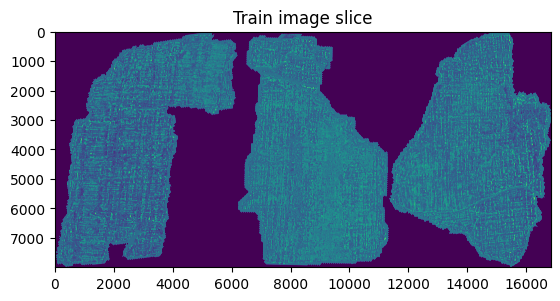

In [ ]:
""" Check the data """
"""
print(f'Image shape {scrolls_dataset.data_train.image_stack.shape}')
fig, ax = plt.subplots()
ax.set_title('Train image slice')
ax.imshow(scrolls_dataset.data_train.image_stack[6]) #.cpu())
plt.show()
"""

Label shape torch.Size([8000, 16836])


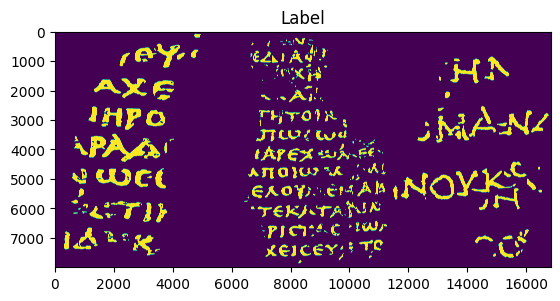

In [ ]:
"""
print(f'Label shape {scrolls_dataset.data_train.label.shape}')
fig, ax = plt.subplots()
ax.set_title('Label')
ax.imshow(scrolls_dataset.data_train.label) #.cpu())
plt.show()
"""

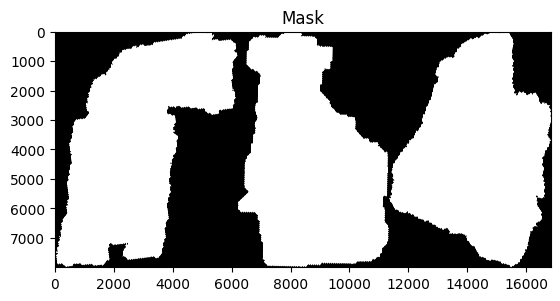

In [ ]:
"""
fig, ax = plt.subplots()
ax.set_title('Mask')
ax.imshow(scrolls_dataset.mask, cmap='gray')
plt.show()
"""

In [ ]:
""" Simulation to traverse the image in Pathes during training """

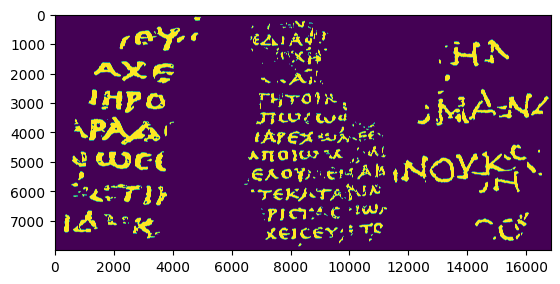

In [ ]:
"""
buffer = 15
fig, ax = plt.subplots()
ax.imshow(scrolls_dataset.data_train.label) #.cpu())
for i in range(10):
  patches_number = np.random.randint(1, len(scrolls_dataset.data_train.pixels))
  x, y = scrolls_dataset.data_train.pixels[patches_number]
  patch = patches.Rectangle([y - buffer, x - buffer], 2*buffer, 2*buffer)
  ax.add_patch(patch)
plt.show()
"""

In [ ]:
"""
scrolls_dataloader = iter(scrolls_dataset.train_dataloader())
"""

In [ ]:
"""
scrolls_dataset.train_dataloader().batch_size, \
scrolls_dataset.train_dataloader().num_workers, \
scrolls_dataset.train_dataloader().prefetch_factor, \
scrolls_dataset.train_dataloader().pin_memory, \
scrolls_dataset.train_dataloader().dataset
"""

(8, 4, 2, False, <__main__.VesuviusDataset at 0x7fd57a8eafd0>)

In [ ]:
"""
scrolls_dataloader = iter(scrolls_dataset.train_dataloader())
for i in range(2):
  subvolume, inklabel, pixels = next(scrolls_dataloader)
  print('sub-volume shape', subvolume.shape, end='\t')
  print('inklabel shape', inklabel.shape)
  print(pixels[0])
  print(inklabel[0], end='t')
  print(inklabel[0]==0)
"""

sub-volume shape torch.Size([8, 1, 10, 61, 61])	inklabel shape torch.Size([8, 1])
tensor([3859, 3766, 4378, 4319, 4206, 3829, 3526, 3773])
tensor([1.])ttensor([False])
sub-volume shape torch.Size([8, 1, 10, 61, 61])	inklabel shape torch.Size([8, 1])
tensor([4138, 3579, 4181, 3659, 4068, 3835, 4237, 4341])
tensor([1.])ttensor([False])


In [ ]:
"""
scrolls_dataset.mask, scrolls_dataset.data_train.label, \
scrolls_dataset.data_train.pixels, scrolls_dataset.data_train.image_stack.shape
"""

In [ ]:
""" data with ink """
"""
scrolls_dataset.data_train.label[5001, 2580], \
scrolls_dataset.data_train.pixels[180000], \
scrolls_dataset.data_train.pixels[180000][0].shape, \
scrolls_dataset.data_train.pixels[180000][1]
"""

(tensor(0.), array([3756, 1644]), (), 1644)

In [ ]:
"""
scrolls_dataset.data_train.__len__(),
"""

(666651,)

In [ ]:
"""
scrolls_dataset.data_train.pixels[0], scrolls_dataset.data_train.pixels[1]
"""

(array([3500, 1100]), array([3500, 1101]))

In [ ]:
"""
scrolls_dataset.data_train.image_stack.shape, \
scrolls_dataset.data_train.label.shape, \
scrolls_dataset.data_train.pixels.shape
"""

(torch.Size([10, 8000, 16836]), torch.Size([8000, 16836]), (666651, 2))

In [ ]:
""" pixels from mask regions """
"""
scrolls_dataset.data_train.pixels.shape
"""

(666651, 2)

In [ ]:
""" pixel entry """
"""
scrolls_dataset.data_train.pixels[560]
"""

array([3500, 1660])

In [ ]:
"""
dataloader_ = iter(scrolls_dataset.train_dataloader())
for i in range(1):
  subvolume, inklabel, pixels = next(dataloader_)

  print('subvolume', subvolume.shape)
  print('inklabel', inklabel.shape)
  print('inklabel', inklabel[0])
  print('inklabel', inklabel[0]==0)
  print('pixels[0]', pixels[0])
  print('pixels[1]', pixels[1])
"""

subvolume torch.Size([8, 1, 10, 61, 61])
inklabel torch.Size([8, 1])
inklabel tensor([1.])
inklabel tensor([False])
pixels[0] tensor([3572, 4055, 3655, 3999, 3745, 3533, 4254, 3621])
pixels[1] tensor([1472, 1516, 1707, 1667, 1127, 1468, 1107, 1159])


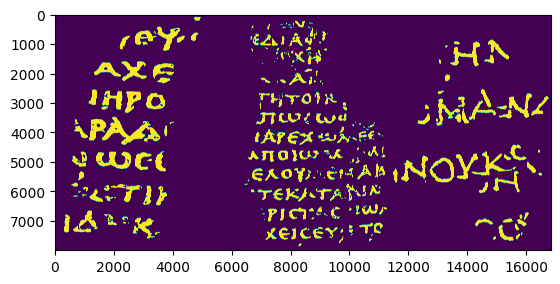

In [ ]:
"""
dataloader_ = iter(scrolls_dataset.train_dataloader())
fig, ax = plt.subplots()
ax.imshow(scrolls_dataset.data_train.label)
buffer=31
for i in range(30*100):
  subvolume, inklabel, pixels = next(dataloader_)
  x, y = pixels
  if inklabel[0] == 0:
    color = 'r'
  else:
    color = 'b'

  patch = patches.Rectangle([y -buffer, x -buffer], 2*buffer, 2*buffer +2)
  #ax.add_patch(patch.)
"""

In [ ]:
"""
scrolls_dataset.data_train.__getitem__(1)
"""

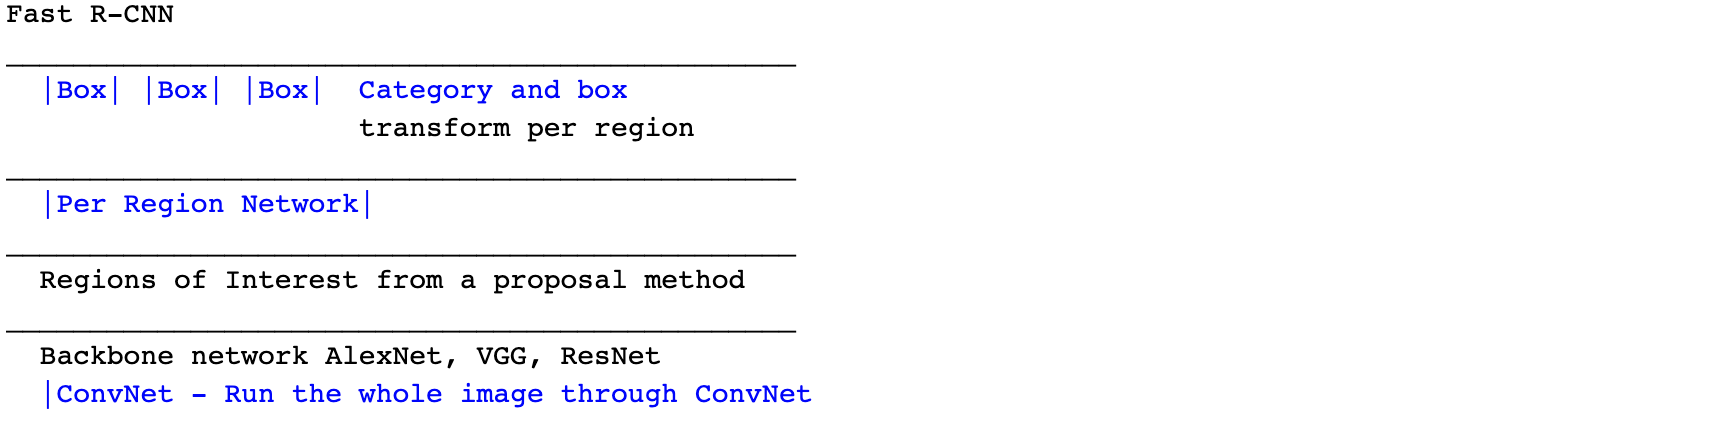

In [ ]:
"""Generic resnet video generator.

Args:
  block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
  conv_makers (
    List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                    function for each layer
    layers (List[int]): number of blocks per layer
    stem (Callable[..., nn.Module]): module specifying the ResNet stem
    num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.
    zero_init_residual (bool, optional):
    Zero init bottleneck residual BN. Defaults to False.
"""

"""
buffer, z_dimension = 30, 10

embedding_dim = 128

resnet_model = torchvision.models.video.r3d_18(weights=None) # (pretrained=False)

backbone = nn.Sequential(
                        resnet_model.stem,
                        resnet_model.layer1,
                        resnet_model.layer2,
                        resnet_model.layer3,
                        resnet_model.layer4)

output_dim = embedding_dim * math.ceil(
                        z_dimension/8) * (math.ceil(buffer*2 +1)/16)**2

bottleneck = nn.Conv3d(512, embedding_dim, 1)
fc = nn.Linear(int(output_dim), 2)
output_dim, bottleneck, fc
"""

(3721.0,
 Conv3d(512, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1)),
 Linear(in_features=3721, out_features=2, bias=True))

In [ ]:
class Vesuvius_ResNet(nn.Module):
  def __init__(self,
               number_of_classes = 2,
               embedding_dimension = 128,
               z_dimension = None,
               buffer = None):
    super().__init__()

    self.num_classes = number_of_classes
    self.embedding_dim = embedding_dimension
    self.batch = 1
    self.batch_index = 1

    resnet_model = torchvision.models.video.r3d_18(weights=None)
    self.backbone = nn.Sequential(resnet_model.stem, resnet_model.layer1,
        resnet_model.layer2, resnet_model.layer3, resnet_model.layer4)

    self.output_dim = int(self.embedding_dim * math.ceil(
                            z_dimension/8) * (math.ceil(buffer*2 +1)/16)**2)
    self.bottleneck = nn.Conv3d(512, self.embedding_dim, 1)
    self.fc = nn.Linear(self.output_dim, self.num_classes)
    self.init_weights()

  def init_weights(self):
    range_init = 0.1
    self.fc.bias.data.zero_()
    self.fc.weight.data.uniform_(-range_init, range_init)
    nn.init.kaiming_normal_(
        self.bottleneck.weight.data, a=0, mode='fan_out', nonlinearity='relu')
    if self.bottleneck.bias is not None:
      _, fan_out = nn.init._calculate_fan_in_and_fan_out(
                                            self.bottleneck.weight.data)
      bound = 1 / math.sqrt(fan_out)
      nn.init.normal_(self.bottleneck.bias, -bound, bound)

  def forward(self, x):
    print(x.shape, x.shape[1])

    if x.shape[1] == 1:
      x = x.repeat(1, 3, 1, 1, 1)

    x = self.backbone(x.float())
    x = self.bottleneck(x)
    x = x.flatten(start_dim=1)
    output = self.fc
    return output

In [ ]:
resnet_model = Vesuvius_ResNet(
    number_of_classes=2, embedding_dimension = 128, z_dimension=10, buffer=31)

In [ ]:
scrolls_dataset = VesuviusDataset_Lit(
              buffer = 31,
              z_start = 27,
              z_dimension = 10,
              validation_rectangle = (1100, 3500, 700, 950),
              shared_height = 8000,
              downsampling = None,
              scroll_fragments = [1, 2, 3],
              stage = 'train',
              shuffle = True,
              batch_size = 3,
              num_workers = 4,
              on_gpu = False
)

In [ ]:
scrolls_dataset.buffer, scrolls_dataset.batch_size

(31, 8)

In [ ]:
scrolls_dataset.prepare_data()

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
1it [00:00,  1.28it/s]
1it [00:00,  1.09it/s]
1it [00:00,  1.50it/s]


In [ ]:
scrolls_dataloader = iter(scrolls_dataset.train_dataloader())
for i in range(1):
  subvolume, inklabel = next(scrolls_dataloader)
  print('sub-volume shape', subvolume.shape, end='\t')
  print('inklabel shape', inklabel.shape)

sub-volume shape torch.Size([8, 1, 1, 63, 63])	inklabel shape torch.Size([8, 1])


In [ ]:
buffer, z_dimension = 31, 10
embedding_dim = 128
resn18_m = torchvision.models.video.r3d_18(weights=None) #(pretrained=False)
backbone = nn.Sequential(resn18_m.stem,
                         resn18_m.layer1,
                         resn18_m.layer2,
                         resn18_m.layer3,
                         resn18_m.layer4)

output_dim = \
    embedding_dim * math.ceil(z_dimension/8) * (math.ceil(buffer*2 +1)/16)**2

bottleneck = nn.Conv3d(512, 128, 1)
output_dim,

(3969.0,)

In [ ]:
bottleneck,

(Conv3d(512, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1)),)

In [ ]:
bottleneck.bias.shape

torch.Size([128])

In [ ]:
fc = nn.Linear(int(output_dim), 2)
fc

Linear(in_features=3721, out_features=2, bias=True)

In [ ]:
fc.weight.data.uniform_(-0.1, 0.1), fc.weight.shape

(tensor([[-0.0002,  0.0208,  0.0768,  ...,  0.0157, -0.0243,  0.0997],
         [ 0.0002, -0.0256,  0.0638,  ..., -0.0338,  0.0384, -0.0183]]),
 torch.Size([2, 3721]))

In [ ]:
fc.bias.data.zero_()

tensor([0., 0.])

In [ ]:
nn.init.kaiming_normal_(bottleneck.weight.data, a=0, mode='fan_out', nonlinearity='relu')

In [ ]:
_, fan_out = nn.init._calculate_fan_in_and_fan_out(bottleneck.weight.data)
fan_out

128

In [ ]:
bound = 1 / math.sqrt(fan_out)
nn.init.normal_(bottleneck.bias, -bound, bound).shape, nn.init.normal_(bottleneck.bias, -bound, bound)

In [ ]:
train_tensor_shape = scrolls_dataset.data_train.image_stack.shape
train_tensor_img = scrolls_dataset.data_train.image_stack
train_tensor_label = scrolls_dataset.data_train.label
train_tensor_label = train_tensor_label.float()
train_tensor_shape, train_tensor_label.shape, train_tensor_label

(torch.Size([1, 8000, 16836]),
 torch.Size([8000, 16836]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
train_tensor_img
""" tensor([[[0., 0., 0.,  ..., 0., 0., 0.],]]], dtype=torch.float64) """

In [ ]:
t_t_s = train_tensor_img.squeeze(1).shape
t_t_s

torch.Size([2, 8000, 16836])

In [ ]:
train_tensor = train_tensor_img.unsqueeze(1)
train_tensor.shape, train_tensor.shape[1] ==1 ,

(torch.Size([1, 1, 8000, 16836]), True)

In [ ]:
if train_tensor.shape[1] == 1:
  train_tensor = train_tensor.repeat(1, 3, 1, 1, 1)
train_tensor.shape

torch.Size([1, 3, 1, 8000, 16836])

In [ ]:
scrolls_dataset.data_train.image_stack.shape, scrolls_dataset.data_train.label.shape, \
scrolls_dataset.data_train.pixels.shape

(torch.Size([10, 8000, 16836]), torch.Size([8000, 16836]), (666651, 2))

In [ ]:
backbone(train_tensor)

In [ ]:
resnet_model.modules

In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([transforms.ToTensor()])

In [ ]:
class Vesuvius_ResNet_Lit(pl.LightningModule):
  def __init__(self,
                model,
                learning_rate: float = 0.0003,
                weight_decay: float = 0.0005,
                milestones = [2, 4, 5, 6, 7, 9, 10, 12, 15, 17, 20, 25],
                gamma: float = 0.85):

    super().__init__()
    self.save_hyperparameters(ignore=['model'])
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
    self.milestones = milestones
    self.gamma = gamma
    self.model = model
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_index):
    images, labels = batch

    loss = self.loss_fn(self.model(torch.squeeze(images, 1)), labels)

    self.log('train loss', loss) #, prog_bar)
    # prog_bar: if ``True`` logs to the progress bar. Log a key, value pair.
    outputs = {'loss': loss}
    return loss

  def validation_step(self, batch, batch_index):
    images, labels = batch

    loss = self.loss_fn(self.model(torch.squeeze(images, 1)), labels)

    self.log('validation loss', loss) #, prog_bar)
    outputs = {'loss': loss}
    return loss

  def test_step(self, batch, batch_index):
    images, targets = batch
    predictions = self.model.predict(images)
    test_errors = self.test_errors(predictions, targets)
    self.log('test errors', test_errors)
    return predictions

  def test_errors(self, predictions, targets):
    return

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.model.parameters(),
                lr=self.learning_rate, weight_decay = self.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                milestones = self.milestones, gamma = self.gamma)
    return [optimizer], [scheduler]


  def configure_optimizers_updated(self):
    optimizer = torch.optim.AdamW(self.model.parameters(),
                lr=self.learning_rate, weight_decay = self.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                milestones = self.milestones, gamma = self.gamma)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr = 0.001, total_steps=100)
    return [optimizer], [scheduler]



In [ ]:
resnet_lit_model = Vesuvius_ResNet_Lit(model=resnet_model)
resnet_lit_model.training_step, resnet_lit_model.forward, \
resnet_lit_model.configure_optimizers
print()

In [ ]:
"""
Trainer
  - accelerator (cpu, gpu, mps)
  - benchmark = True
  - max_epoch
  - check_val_every_n_epoch = 1
  - devices = 1
  - fast_dev_run
  - logger = pl.loggers.CSVLogger(save_dir='/tmp/logs/*)
  - log_every_n_steps = 1
  - overfit_batches = 0
  - precision = 16
  - accumulate_grad_batches = 8
  - strategy = 'ddp' if devices > 1 else None
"""
trainer = pl.Trainer(
    accelerator='cpu',
    benchmark = True,
    max_epochs=1,
    devices=1,
    #accumulate_grad_batches = 8
)
PATHTRAIN = f'/content/drive/MyDrive/A_Vesuvius/'

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [ ]:
resnet_lit_model.parameters

In [ ]:
trainer.fit(resnet_lit_model, datamodule=scrolls_dataset)

In [ ]:
gc.collect()

151

### U-Net Architecture for Segmentation

UnetLit:

In [ ]:
!pip install monai

In [ ]:
VesuviusDataset_U

__main__.VesuviusDataset_U

In [ ]:
""" generate csv files for the data train and data test """

In [ ]:
class DataFrameDataset(pl.LightningDataModule):
  def __init__(self,
               patch_size = 512,
               z_start = 0,
               z_dimension = 64,
               shared_height = None,
               downsampling = None,
               train_fragment = [1, 2],
               val_fragment = [3],
               stage = 'train',
               batch_size = 1,
               num_samples = 1,
               num_workers = 0,
               on_gpu = False,
               data_path = None):
    super().__init__()
    self.save_hyperparameters()

    self.df = pd.read_csv(data_path)
    self.keys = ('volume_npy', 'mask_npy', 'label_npy')
    self.train_transform = self.train_transforms()
    self.val_transform = self.val_transforms()
    self.predict_transform = self.predict_transforms()


  def setup(self, stage=None):
    if stage == 'fit' or stage is None:
      train_val_df = self.df[self.df.stage == 'train'].reset_index(drop=True)

      train_df = train_val_df[
          train_val_df.fragment_id != self.hparams.val_fragment_id].reset_index(drop=True)
      self.train_dataset = self._dataset(train_df, self.train_transform)
      del train_df

      val_df =  train_val_df[
        train_val_df.fragment_id != self.hparams.train_fragment_id].reset_index(drop=True)
      self.val_dataset = self._dataset(val_df, self.val_transform)
      del val_df

      del train_val_df

    if stage == 'predict' or stage is None:
      predict_df = self.df[self.df.stage == 'test'].reset_index(drop=True)
      self.predict_dataset = self._dataset(predict_df, self.predict_transform)
      del predict_df


  def df_dataset(self, df, transform):
    return CSVDataset(
        src = df, transform = transform
    )


  def train_transforms(self):
    return monai.transforms.Compose([
      monai.transforms.LoadImaged(keys = 'volume_npy'),
      monai.transforms.LoadImages(
        keys = ('mask_npy', 'label_npy'), ensure_channel_first = True),
      monai.transforms.RandWeightsCropd(
        keys = ('volume_npy', 'mask_npy', 'label_npy'),
        spatial_size = self.hparams.patch_size,
        num_samples = self.hparams.num_samples, w_key = 'mask_npy'),
      monai.transforms.RandFlipd(
        keys = self.keys, prob=0.5, spatial_axis = 0),
      monai.transforms.RandFlipd(
        keys = self.keys, prob=0.5, spatial_axis = 1),
    ])


  def val_transforms(self):
    return monai.transforms.Compose([
      monai.transforms.LoadImaged(keys = 'volume_npy'),
      monai.transforms.LoadImaged(
        keys = ('mask_npy', 'label_npy'), ensure_channel_first=True),
      monai.transforms.RandWeightedCropd(
        keys = ('volume_npy', 'mask_npy', 'label_npy'),
        spatial_size = self.hparams.patch_size,
        num_samples = self.hparams.num_samples, w_key = 'mask_npy')
    ])


  def predict_transforms(self):
    return monai.transforms.Compose([
      monai.transforms.LoadImaged(keys = 'volume_npy'),
      monai.transforms.LoadImaged(keys = 'mask_npy', ensure_channel_first=True))
    ])


  def train_dataloader(self):
    return self._dataloader(self.train_dataset, train=True)


  def val_dataloader(self):
    return self._dataloader(self.val_dataset)


  def predict_dataloader(self):
    return self._dataloader(self.predict_dataset)


  def _dataloader(self, dataset, train=False):
    return DataLoader(
        dataset,
    )


In [ ]:
class VesuviusDataset_Lit_UNet(pl.LightningDataModule):
  def __init__(self,
               patch_size = 512,
               #buffer = 30,
               z_start = 27,
               z_dimension = 10,
               validation_rectangle = (1100, 3500, 700, 950),
               shared_height = 8000,
               downsampling = None,
               #scroll_fragments = [1, 2, 3],
               train_scroll_fragments = [1, 2],
               val_scroll_fragments = [3],
               stage = 'train',
               #shuffle = True,
               batch_size = 8, #32
               num_workers = 4,
               on_gpu = False
      ):

      super().__init__()
      self.save_hyperparameters()

      self.patch_size = patch_size,
      self.z_start = z_start
      self.z_dimension = z_dimension
      self.validation_rectangle = validation_rectangle
      self.downsampling = downsampling
      self.train_scroll_fragments = train_scroll_fragments
      self.val_scroll_fragments = val_scroll_fragments
      self.num_workers = num_workers
      self.stage = stage
      self.shared_height = shared_height
      self.batch_size = batch_size
      self.on_gpu = on_gpu
      self.prepare_data_per_node = True

  def prepare_data(self, *args, **kwargs):
    if self.stage == 'train':

      z_slices = [[] for i in range(len(self.scroll_fragments))]
      labels = [[] for i in range(len(self.scroll_fragments))]
      masks =  [[] for i in range(len(self.scroll_fragments))]

      z_slices_val = [[] for i in range(len(self.scroll_fragments))]
      labels_val = [[] for i in range(len(self.scroll_fragments))]
      masks_val =  [[] for i in range(len(self.scroll_fragments))]

      """ get z_slices .tif(s) files for scroll fragments [1, 2, 3]
          get labels, and masks for the scroll 1, 2, 3  """
      for i in self.train_scroll_fragments:
        z_slices[i -1] += sorted(
            glob.glob(f'{PATHTRAIN}train/{i}/surface_volume/*.tif'))[
                              self.z_start : self.z_start + self.z_dimension]
        labels[i -1] = self.load_labels('train', i)
        masks[i -1] = self.load_masks('train', i)

      for i in self.val_scroll_fragments:
        z_slices_val[i -1] += sorted(
            glob.glob(f'{PATHTRAIN}train/{i}/surface_volume/*.tif'))[
                              self.z_start : self.z_start + self.z_dimension]
        labels_val[i -1] = self.load_labels('train', i)
        masks_val[i -1] = self.load_masks('train', i)

      images = [[] for _ in range(len(self.train_scroll_fragments))]
      for i in range(len(self.train_scroll_fragments)):
          images[i] = self.load_slices(z_slices[i])

      images_val = [[]]
      images_val[0] = self.load_slices(z_slices_val[0])

      """ images, labels and mask tensors """
      image_tensors = torch.cat([image for image in images], axis=-1)
      del images
      label_tensors = torch.cat([label for label in labels], axis=-1)
      del labels
      mask_tensors = np.concatenate([mask for mask in masks], axis=-1)
      del masks
      mask_tensors = torch.from_numpy(mask_tensors)

      image_tensors_val = torch.cat([image for image in images_val], axis=-1)
      del images_val
      label_tensors_val = torch.cat([label for label in labels_val], axis=-1)
      del labels_val
      mask_tensors_val = np.concatenate([mask for mask in masks_val], axis=-1)
      del masks_val
      mask_tensors_val = torch.from_numpy(mask_tensors_val)

      array_dataset = monai.data.ArrayDataset(
          img = image_tensors.unsqueeze(0),
          seg = mask_tensors.unsqueeze(0).unsqueeze(0),
          labels = label_tensors.unsqueeze(0).unsqueeze(0),
      )
      del image_tensors ; del label_tensors ; del mask_tensors

      array_dataset_val = monai.data.ArrayDataset(
          img = image_tensors_val.unsqueeze(0),
          seg = mask_tensors_val.unsqueeze(0).unsqueeze(0),
          labels = label_tensors_val.unsqueeze(0).unsqueeze(0),
      )
      del image_tensors_val ; del label_tensors_val ; del mask_tensors_val

      patch_iter = monai.data.PatchIter(
                              patch_size = (self.patch_size, self.patch_size))

      def image_sequence_iter(x):
        for img, seg, label in zip(patch_iter[0], patch_iter[1], patch_iter[2]):
          yields (img[0], seg[0], label[0],)

      self.data_train = monai.data.GridPatchDataset(
          array_dataset, patch_iter=image_sequence_iter, with_coordinates=False)
      del array_dataset

      self.data_train_val = monai.data.GridPatchDataset(
          array_dataset_val, patch_iter=image_sequence_iter, with_coordinates=False)
      del array_dataset_val


    elif self.stage == 'test':
      z_slices = [ [], [] ]


  def train_dataloader(self, *args, **kwargs):
    """ constructor for train dataloader  """
    return DataLoader(self.data_train,
                      shuffle=True,
                      batch_size=self.batch_size,
                      num_workers = self.num_workers,
                      pin_memory = self.on_gpu)

  def test_dataloader(self, *args, **kwargs):
    """ constructor for test dataloader  """
    return DataLoader(self.data_test,
                      shuffle=False,
                      batch_size=self.batch_size,
                      num_workers = self.num_workers,
                      pin_memory = self.on_gpu)

  def val_dataloader(self, *args, **kwargs):
    """ constructor for validation dataloader  """
    return DataLoader(self.data_val,
                      shuffle=False,
                      batch_size=self.batch_size,
                      num_workers = self.num_workers,
                      pin_memory = self.on_gpu)

  def load_slices(self, z_slices_files):
    """ we convert the batch of z_slices images into image tensors """
    images_ = []
    for z, z_slice_file in tqdm(enumerate(z_slices_files)):
      image_ = Image.open(z_slice_file)
      image_ = self.image_resize(image_)
      image_arr = np.array(image_, dtype=float)/65535.0
      images_.append(image_arr)

    """ use np.vstack or torch.stack for consistency with torch """
    image_stack = torch.stack(
        [torch.from_numpy(image) for image in images_], dim=0) #.to(DEVICE)
    return  image_stack

  def load_labels(self, split, index):
    img_ = Image.open(f'{PATHTRAIN}/{split}/{index}/inklabels.png')
    img_ = self.image_resize(img_)
    img_ = torch.from_numpy(np.array(img_)).gt(0).float() #.to(DEVICE)
    return img_

  def load_masks(self, split, index):
    img_ = Image.open(f'{PATHTRAIN}/{split}/{index}/mask.png').convert('1')
    img_ = self.image_resize(img_)
    return np.array(img_)

  def image_resize(self, image):
    actual_width, actual_height = image.size
    aspect_ratio = actual_width/actual_height
    new_width = int(self.shared_height * aspect_ratio)
    new_size = (new_width, self.shared_height)
    image = image.resize(new_size)
    return image


  def split_train_validate(self, mask):
     rectangle = self.validation_rectangle               # 1250, 1500, 780, 850
     not_border = np.zeros(mask.shape, dtype=bool)
     not_border[self.buffer: mask.shape[0] - self.buffer,
                self.buffer: mask.shape[1] - self.buffer]  = True
     array_mask = np.array(mask) * not_border
     inside_rectangle = np.zeros(mask.shape, dtype=bool) * array_mask
     inside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] +1,
                      rectangle[0]:rectangle[0] + rectangle[2] +1] = True
     outside_rectangle = np.ones(mask.shape, dtype=bool) * array_mask
     outside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] + 1,
                       rectangle[0]:rectangle[0] + rectangle[2] + 1] = False
     pixels_inside_rectangle = np.argwhere(inside_rectangle)
     pixels_outside_rectangle = np.argwhere(outside_rectangle)

     return pixels_inside_rectangle, pixels_outside_rectangle

  def image_resize(self, image):
    actual_width, actual_height = image.size
    aspect_ratio = actual_width/actual_height
    new_width = int(self.shared_height * aspect_ratio)
    new_size = (new_width, self.shared_height)
    image = image.resize(new_size)
    return image


In [ ]:
""" test the dataset """

In [ ]:
from torch.nn.modules.loss import L1Loss
class v_UNetMonai_Lit(pl.LightningModule):
  def __init__(self,
              z_dimension = 32,
              patch_size = (512, 512),
              sw_batch_size = 16,
              eta_min = 1e-6,
              t_max = 75,
              max_epochs = 700,
              weight_decay: float = 0.0001,
              learning_rate: float = 0.0003,
              gamma: float = 0.85,
              milestones = [100, 150, 200, 250, 300, 350, 400, 450, 500]
  ):

    super().__init__()
    self.save_hyperparameters()

    self.z_dimension = z_dimension,
    self.metrics = self._init_metrics()
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
    self.milestones = milestones
    self.gamma = gamma
    self.model = self._init_model()
    self.loss = self._init_loss()

  def _init_model(self):
    return monai.networks.nets.UNet(
        spatial_dim = 2,
        in_channels = self.z_dimension,
        out_channels = 1,
        channels = (64, 128, 256, 512, 1024),
        strides = (2, 2, 2, 2),
        num_res_units = 4,
        dropout = .3 # 0
    )

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_index):
    images = batch['image_npy'].as_tensor()
    labels = batch['label_npy'].long()
    masks = batch['mask_npy']
    outputs = self.model(images)

    loss = self.loss(outputs, labels, masks)

    self.log('train loss', loss.as_tensor(), on_step=True, om_epoch=True, prog_bar=True)
    self.metrics['train_metrics'](outputs, labels)

    outputs = {'loss': loss}
    return loss


  def validation_step(self, batch, batch_index):
    images = batch['image_npy'].as_tensor()
    labels = batch['label_npy'].long()
    masks = batch['mask_npy']
    outputs = self.model(images)

    loss = self.loss(outputs, labels, masks)
    preds = torch.sigmoid(outputs.detach()).gt(.4).int()

    accuracy = \
      (preds == labels).sum().float().div(labels.size(0)*labels.size(2) **2)

    fbeta_score = FBetaScore(task='binary', beta=.5, threshold=.4)
    fbeta = fbeta_score(torch.sigmoid(outputs), labels)
    fbeta_score_vesuvius = \
            self.fbeta_score_vesuvius(torch.sigmoid(outputs), labels)

    self.log('val loss', loss.as_tensor(), on_step=True, om_epoch=True, prog_bar=True)
    self.log('accuracy', accuracy, on_step=True, om_epoch=True, prog_bar=True)
    self.log('fbeta', fbeta, on_step=True, om_epoch=True, prog_bar=True)
    #self.log('fbeta_score_vesuvius', fbeta_score_vesuvius, on_step=True, om_epoch=True, prog_bar=True)

    self.metrics['val_metrics'](outputs, labels)

    outputs = {'loss': loss}
    return loss


  def predict_step(self, batch, batch_index):
    images = batch['volume_npy'].as_tensor()
    masks = batch['masks_npy']
    outputs = sliding_window_inference(
        inputs=images,
        roi_size=self.hparams.patch_size,
        sw_batch_size = self.hparams.sw_batch_size,
        predict=self
    )
    return outputs.sigmoid().squeeze()


  def _init_loss(self):
    loss = monai.losses.DiceLoss(sigmoid=True)
    return monai.losses.MaskedLoss(loss)


  def _init_metrics(self):
    metric_collection = MetricCollection(
        { 'dice': Dice()}
    )
    return torch.nn.ModuleDict(
        {
            'train_metrics': metric_collection.clone(prefix='train_'),
            'val_metrics': metric_collection.clone(prefix = 'val_')
        }
    )


  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.model.parameters(),
                            lr=self.lr, weight_decay=self.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                            milestones=self.milestones, gamma = self.gamma)
    return [optimizer], [scheduler]

  def fbeta_score_vesuvius(self,
                           preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = target.sum()

    ctp = preds_t[targets ==1].sum()
    cfp = preds_t(targets ==0).sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = cfp / (y_true_count + smooth)
    res = (1 + beta_squared) * (c_precision * c_recall) \
                    / (beta_squared * c_precision + c_recall)

In [ ]:
""" VesuviusDataset_U Unet dataset """

Script
- load labels
- load mask
- load z-slices - volume
- sample location
- train dataset
- create convolutional-model
- compile and fit the model
- save the model


Semantic Segmentation outline
- Object Detection
- Slow R-CNN
- Fast R-CNN
- Faster R-CNN
- Semantic Segmentation
- Mask R-CNN
- Segmentation Models

F5 Score, RLE, Sample Rnadom, Trivial Baseline

In [ ]:
def f5_score(predicted, actual):
  batch_size = predicted.shape[0]
  true_positive = (
      (predicted == 1) and (actual ==1)).reshape(batch_size, -1).sum(-1)
  true_negative = (
      (predicted == 0) and (actual ==1)).reshape(batch_size, -1).sum(-1)
  false_positive = (
      (predicted == 1) and (actual ==0)).reshape(batch_size, -1).sum(-1)
  false_negative = (
      (predicted == 0) and (actual ==1)).reshape(batch_size, -1).sum(-1)

  precision = true_positive / (true_positive + false_positive)
  recall =  true_positive / (true_positive + false_negative)
  f5_score_ = (1.25 *precision*recall)/(0.25*precision + recall)

In [ ]:
def run_length_encoding(x):
  flatten_image  = x.flatten('C')
  flatten_image = np.where(flatten_image > 0.5, 1, 0).astype(np.uint8)
  start_edge = np.array((flatten_image[:-1] ==0) and (flatten_image[1:] ==1))
  start_edge = np.append(np.array((flatten_image[0] ==1)), start_edge)
  end_edge = np.array((flatten_image[:-1] ==1) and (flatten_image[1:] ==0))
  end_edge = np.append(np.array((flatten_image[-1] ==1)), start_edge)
  start_edge_ix = np.where(start_edge)[0] + 1
  end_edge_ix = np.where(end_edge)[0] + 1
  lengths = end_edge_ix - start_edge_ix + 1
  encoded = ''
  for start_, len_ in zip(start_edge_ix, lengths): encoded += f'{start_}{len_}'
  encoded.strip()
  return encoded


In [ ]:
import tensorflow as tf
def sample_random(shape):
  random_train_x = tf.random.uniform(
      shape=(), minval=buffer, maxval=shape[0] -buffer -1, dtype='int32')
  random_train_y = tf.random.uniform(
      shape=(), minval=buffer, maxval=shape[1] -buffer -1, dtype='int32')
  random_train_xy = tf.stack([random_train_x, random_train_y])


In [ ]:
""" compute a trivial baseline dataset with the highest validation score """
def trivial_baseline(dataset):
  for _, batch_label in tqdm(dataset):
    matches += tf.reduce_sum(tf.cast(batch_label, 'float32'))
    total += tf.reduce_prod(tf.shape(batch_label))

  return 1 - matches/tf.cast(total, 'float32')

score = trivial_baseline(scrolls_dataset)
print(f'best validation scrore achieved trivially {score *100:.2f}% accuracy')

Define Model with Keras

Residual U-net with Keras - Move to a separate Notebook (Similar to Francois')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def convBlock(x, filters, apply_batchnorm=False, apply_dropout=False):
  x_1 = layers.Conv2D(filters=filters, kernel_size=3,
                     strides=1, padding='same', activation='relu')(x)
  x_2 = layers.Concatenate()[x, x_1]
  outputs = layers.Conv2D(filters=filters, kernel_size=3,
                     strides=1, padding='same', activation='relu')(x_2)

  if apply_batchnorm: outputs = layers.BatchNormalization()(outputs)
  if apply_dropout: outputs = layers.Dropout(0.25)(outputs)
  return outputs

In [ ]:
def downsample(x, filters, apply_batchnorm=False, apply_dropout=False):
  outputs = layers.Conv2D(filters=filters, kernel_size=4,
                     strides=2, padding='same', activation='relu')(x)

  if apply_batchnorm: outputs = layers.BatchNormalization()(outputs)
  if apply_dropout: outputs = layers.Dropout(0.25)(outputs)
  return outputs

In [ ]:
def upsample(x, filters, apply_batchnorm=False, apply_dropout=False):
  outputs = layers.UpSampling2D(size=(2,2), interpolation='nearest')(x)
  outputs = layers.Conv2D(filters=filters, kernel_size=3,
                     strides=1, padding='same', activation='relu')(outputs)

  if apply_batchnorm: outputs = layers.BatchNormalization()(outputs)
  if apply_dropout: outputs = layers.Dropout(0.25)(outputs)
  return outputs

In [ ]:
""" with the pytorch lit model we had 3.3 million training parameters
this will have 4 million approximately """
